# Bangla Sentiment Analysis - Complete Solution

This notebook implements a comprehensive sentiment analysis system for Bangla text, addressing underfitting issues with improved architecture and training strategies.

## 1. Setup and Imports

In [1]:
# Install required packages
!pip install --upgrade pip setuptools wheel -q
!pip install torch==2.0.1 --index-url https://download.pytorch.org/whl/cu118 -q
!pip install transformers==4.30.2 tokenizers==0.13.3 -q
!pip install scikit-learn pandas numpy matplotlib seaborn tqdm -q
!pip install nltk -q

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau

# NLP Processing
import re
import string
from collections import Counter, defaultdict
import nltk

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# System utilities
import gc
import json
import random
from datetime import datetime

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Create directories
for dir_name in ['plots', 'models', 'results', 'embeddings']:
    os.makedirs(dir_name, exist_ok=True)

print("Setup completed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pandas-gbq 0.29.1 requires google-api-core<3.0.0,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 10.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 2. Load and Analyze Dataset

In [2]:
# Load dataset
df = pd.read_csv('/kaggle/input/final-dataset/final-dataset.csv')
print(f"Original dataset shape: {df.shape}")

# Check unique polarities to determine number of classes
unique_polarities = df['Polarity'].unique()
print(f"\nUnique polarities found: {unique_polarities}")

# Map polarities based on what's in the dataset
if 'neutral' in unique_polarities:
    # 3-class case
    num_classes = 3
    df['Polarity'] = df['Polarity'].map({'positive': 1, 'negative': 0, 'neutral': 2})
    class_names = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
    print("\nDetected 3-class sentiment analysis")
else:
    # 2-class case
    num_classes = 2
    df['Polarity'] = df['Polarity'].map({'positive': 1, 'negative': 0})
    class_names = {0: 'Negative', 1: 'Positive'}
    print("\nDetected 2-class sentiment analysis")

print(f"Number of classes: {num_classes}")
print("\nClass distribution:")
print(df['Polarity'].value_counts().sort_index())

# Add text statistics
df['text_length'] = df['Text'].str.len()
df['word_count'] = df['Text'].str.split().str.len()

print(f"\nAverage text length: {df['text_length'].mean():.1f} characters")
print(f"Average word count: {df['word_count'].mean():.1f} words")

Original dataset shape: (6180, 2)

Unique polarities found: ['positive' 'neutral' 'negative']

Detected 3-class sentiment analysis
Number of classes: 3

Class distribution:
Polarity
0    1977
1    2048
2    2155
Name: count, dtype: int64

Average text length: 74.9 characters
Average word count: 12.7 words


## 3. Text Preprocessing

In [3]:
class BanglaTextPreprocessor:
    """Text preprocessing for Bangla text"""
    
    def __init__(self, min_word_freq=2):
        self.min_word_freq = min_word_freq
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}
        self.idx2word = {0: '<PAD>', 1: '<UNK>', 2: '<SOS>', 3: '<EOS>'}
        self.word_freq = Counter()
        self.vocab_size = 4
        
        # Common Bangla punctuation
        self.bangla_punct = '।॥,;:!?\'"-.…'
        
    def clean_text(self, text):
        """Basic cleaning for Bangla text"""
        # Convert to string
        text = str(text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        # Keep Bangla characters, numbers, and basic punctuation
        # This regex keeps Bangla Unicode range and common characters
        text = re.sub(r'[^\u0980-\u09FF\s0-9।,!?.-]', ' ', text)
        
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text)
        
        return text.strip()
    
    def tokenize(self, text):
        """Simple word tokenization for Bangla"""
        # Clean text first
        text = self.clean_text(text)
        
        # Simple split-based tokenization
        tokens = text.split()
        
        return tokens
    
    def build_vocab(self, texts):
        """Build vocabulary from texts"""
        # Count word frequencies
        for text in tqdm(texts, desc="Building vocabulary"):
            tokens = self.tokenize(text)
            self.word_freq.update(tokens)
        
        # Add words that meet minimum frequency
        for word, freq in self.word_freq.items():
            if freq >= self.min_word_freq:
                if word not in self.word2idx:
                    self.word2idx[word] = self.vocab_size
                    self.idx2word[self.vocab_size] = word
                    self.vocab_size += 1
        
        print(f"Vocabulary size: {self.vocab_size}")
        print(f"Number of unique words: {len(self.word_freq)}")
        print(f"Words meeting min frequency: {self.vocab_size - 4}")  # Excluding special tokens
        
    def text_to_indices(self, text, max_length=None):
        """Convert text to indices"""
        tokens = self.tokenize(text)
        
        # Convert to indices
        indices = [self.word2idx.get(token, 1) for token in tokens]  # 1 is <UNK>
        
        # Add SOS and EOS
        indices = [2] + indices + [3]  # 2 is <SOS>, 3 is <EOS>
        
        # Truncate or pad if max_length specified
        if max_length:
            if len(indices) > max_length:
                indices = indices[:max_length-1] + [3]  # Keep EOS
            else:
                indices = indices + [0] * (max_length - len(indices))  # 0 is <PAD>
        
        return indices
    
    def texts_to_sequences(self, texts, max_length=None):
        """Convert multiple texts to sequences"""
        sequences = []
        for text in tqdm(texts, desc="Converting texts to sequences"):
            sequences.append(self.text_to_indices(text, max_length))
        return sequences

# Initialize preprocessor
preprocessor = BanglaTextPreprocessor(min_word_freq=2)

# Build vocabulary
print("Building vocabulary...")
preprocessor.build_vocab(df['Text'].values)

# Convert texts to sequences
max_seq_length = 100  # Maximum sequence length
sequences = preprocessor.texts_to_sequences(df['Text'].values, max_length=max_seq_length)

print(f"\nSequence shape: {len(sequences)} x {max_seq_length}")
print(f"Sample sequence: {sequences[0][:20]}...")

Building vocabulary...


Building vocabulary:   0%|          | 0/6180 [00:00<?, ?it/s]

Vocabulary size: 6476
Number of unique words: 18383
Words meeting min frequency: 6472


Converting texts to sequences:   0%|          | 0/6180 [00:00<?, ?it/s]


Sequence shape: 6180 x 100
Sample sequence: [2, 4, 5, 6, 7, 8, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...


## 4. Train Word2Vec Embeddings


In [4]:
def create_embedding_matrix(vocab_size, embedding_dim=100, method='random'):
    """Create embedding matrix using different methods"""
    
    print(f"Creating {method} embedding matrix...")
    
    if method == 'random':
        # Random initialization
        embedding_matrix = np.random.normal(0, 0.1, (vocab_size, embedding_dim))
        # Special tokens get different initialization
        embedding_matrix[0] = np.zeros(embedding_dim)  # PAD token
        
    elif method == 'one_hot':
        # One-hot encoding (not recommended for large vocab)
        embedding_matrix = np.eye(vocab_size)[:, :embedding_dim]
        
    else:  # Default to random
        embedding_matrix = np.random.normal(0, 0.1, (vocab_size, embedding_dim))
    
    print(f"Embedding matrix shape: {embedding_matrix.shape}")
    return embedding_matrix

# Create embedding matrix using random initialization
embedding_dim = 100
embedding_matrix = create_embedding_matrix(preprocessor.vocab_size, embedding_dim, method='random')

# Optional: Create a simple frequency-based weighting
print("\nApplying frequency-based adjustments...")
for word, idx in preprocessor.word2idx.items():
    if idx < 4:  # Skip special tokens
        continue
    # Adjust embeddings based on frequency (optional)
    freq = preprocessor.word_freq.get(word, 1)
    # Words with higher frequency get slightly different initialization
    if freq > 10:
        embedding_matrix[idx] *= 1.1
    elif freq < 3:
        embedding_matrix[idx] *= 0.9

print("Embedding matrix created successfully!")

Creating random embedding matrix...
Embedding matrix shape: (6476, 100)

Applying frequency-based adjustments...
Embedding matrix created successfully!


# Cell 5 - Create Dataset Class


In [5]:
class BanglaDataset(Dataset):
    """Dataset class for Bangla sentiment analysis"""
    
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return {
            'sequence': torch.tensor(self.sequences[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

def create_data_loaders(sequences, labels, batch_size=32, val_split=0.2, test_split=0.1):
    """Create train, validation, and test data loaders"""
    
    # Convert to numpy arrays
    sequences = np.array(sequences)
    labels = np.array(labels)
    
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        sequences, labels, test_size=test_split, stratify=labels, random_state=42
    )
    
    # Second split: separate train and validation
    val_size = val_split / (1 - test_split)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, stratify=y_temp, random_state=42
    )
    
    print(f"Train: {len(X_train)} samples")
    print(f"Val: {len(X_val)} samples")
    print(f"Test: {len(X_test)} samples")
    
    # Create datasets
    train_dataset = BanglaDataset(X_train, y_train)
    val_dataset = BanglaDataset(X_val, y_val)
    test_dataset = BanglaDataset(X_test, y_test)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, (X_train, X_val, X_test, y_train, y_val, y_test)

# Create data loaders
train_loader, val_loader, test_loader, data_splits = create_data_loaders(
    sequences, 
    df['Polarity'].values,
    batch_size=64,
    val_split=0.2,
    test_split=0.1
)

Train: 4326 samples
Val: 1236 samples
Test: 618 samples


# Cell 6 - CNN Model

In [6]:
class CNNSentimentClassifier(nn.Module):
    """CNN model for sentiment classification"""
    
    def __init__(self, vocab_size, embedding_dim, num_classes, 
                 embedding_matrix=None, num_filters=100, filter_sizes=[3, 4, 5], 
                 dropout=0.5, freeze_embeddings=False):
        super(CNNSentimentClassifier, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Initialize with pre-trained embeddings if provided
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix).float())
            # Optionally freeze embeddings
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False
        
        # Convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=k)
            for k in filter_sizes
        ])
        
        # Batch normalization
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(num_filters)
            for _ in filter_sizes
        ])
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers
        fc_input_dim = len(filter_sizes) * num_filters
        self.fc1 = nn.Linear(fc_input_dim, 128)
        self.batch_norm_fc = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        x = x.permute(0, 2, 1)  # (batch_size, embedding_dim, seq_len)
        
        # Apply convolutions
        conv_outputs = []
        for conv, bn in zip(self.convs, self.batch_norms):
            conv_out = conv(x)  # (batch_size, num_filters, new_seq_len)
            conv_out = bn(conv_out)  # Batch normalization
            conv_out = self.relu(conv_out)
            # Max pooling over time
            pooled = F.max_pool1d(conv_out, conv_out.size(2))  # (batch_size, num_filters, 1)
            pooled = pooled.squeeze(2)  # (batch_size, num_filters)
            conv_outputs.append(pooled)
        
        # Concatenate all conv outputs
        x = torch.cat(conv_outputs, dim=1)  # (batch_size, len(filter_sizes) * num_filters)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.batch_norm_fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Initialize CNN model
cnn_model = CNNSentimentClassifier(
    vocab_size=preprocessor.vocab_size,
    embedding_dim=100,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    dropout=0.5,
    freeze_embeddings=False
).to(device)

print(f"CNN Model initialized")
print(f"Total parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in cnn_model.parameters() if p.requires_grad):,}")

CNN Model initialized
Total parameters: 807,671
Trainable parameters: 807,671


## Cell 7 - BiLSTM Model


In [7]:
class BiLSTMSentimentClassifier(nn.Module):
    """Bidirectional LSTM model for sentiment classification"""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, 
                 num_classes, embedding_matrix=None, dropout=0.5, freeze_embeddings=False):
        super(BiLSTMSentimentClassifier, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Initialize with pre-trained embeddings if provided
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix).float())
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False
        
        # BiLSTM layers
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers
        # *2 for bidirectional
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.batch_norm = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Activation
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def attention_weights(self, lstm_output):
        """Calculate attention weights"""
        # lstm_output shape: (batch_size, seq_len, hidden_dim * 2)
        attention_scores = self.attention(lstm_output)  # (batch_size, seq_len, 1)
        attention_scores = attention_scores.squeeze(-1)  # (batch_size, seq_len)
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, seq_len)
        return attention_weights
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        
        # Get actual lengths (before padding)
        lengths = (x != 0).sum(dim=1).cpu()
        
        # Embedding
        x = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        
        # Pack padded sequence
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        
        # LSTM
        packed_output, (hidden, cell) = self.lstm(packed)
        
        # Unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )
        # output shape: (batch_size, seq_len, hidden_dim * 2)
        
        # Apply attention
        attention_weights = self.attention_weights(output)
        # attention_weights shape: (batch_size, seq_len)
        
        # Apply attention to get weighted representation
        attended = torch.bmm(
            attention_weights.unsqueeze(1), 
            output
        ).squeeze(1)
        # attended shape: (batch_size, hidden_dim * 2)
        
        # Apply dropout
        attended = self.dropout(attended)
        
        # Fully connected layers
        x = self.fc1(attended)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Initialize BiLSTM model
bilstm_model = BiLSTMSentimentClassifier(
    vocab_size=preprocessor.vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    num_layers=2,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix,
    dropout=0.5,
    freeze_embeddings=False
).to(device)

print(f"BiLSTM Model initialized with Attention")
print(f"Total parameters: {sum(p.numel() for p in bilstm_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in bilstm_model.parameters() if p.requires_grad):,}")

BiLSTM Model initialized with Attention
Total parameters: 1,312,180
Trainable parameters: 1,312,180


# Cell 7a - GRU Model


In [8]:
class GRUSentimentClassifier(nn.Module):
    """GRU model for sentiment classification"""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, 
                 num_classes, embedding_matrix=None, dropout=0.5, freeze_embeddings=False):
        super(GRUSentimentClassifier, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Initialize with pre-trained embeddings if provided
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix).float())
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False
        
        # GRU layers
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers
        # *2 for bidirectional
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.batch_norm = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Activation
        self.relu = nn.ReLU()
        
    def attention_weights(self, gru_output):
        """Calculate attention weights"""
        # gru_output shape: (batch_size, seq_len, hidden_dim * 2)
        attention_scores = self.attention(gru_output)  # (batch_size, seq_len, 1)
        attention_scores = attention_scores.squeeze(-1)  # (batch_size, seq_len)
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, seq_len)
        return attention_weights
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        
        # Get actual lengths (before padding)
        lengths = (x != 0).sum(dim=1).cpu()
        
        # Embedding
        x = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        
        # Pack padded sequence
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        
        # GRU
        packed_output, hidden = self.gru(packed)
        
        # Unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )
        # output shape: (batch_size, seq_len, hidden_dim * 2)
        
        # Apply attention
        attention_weights = self.attention_weights(output)
        
        # Apply attention to get weighted representation
        attended = torch.bmm(
            attention_weights.unsqueeze(1), 
            output
        ).squeeze(1)
        # attended shape: (batch_size, hidden_dim * 2)
        
        # Apply dropout
        attended = self.dropout(attended)
        
        # Fully connected layers
        x = self.fc1(attended)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Initialize GRU model
gru_model = GRUSentimentClassifier(
    vocab_size=preprocessor.vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    num_layers=2,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix,
    dropout=0.5,
    freeze_embeddings=False
).to(device)

print(f"GRU Model initialized with Attention")
print(f"Total parameters: {sum(p.numel() for p in gru_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in gru_model.parameters() if p.requires_grad):,}")

GRU Model initialized with Attention
Total parameters: 1,154,484
Trainable parameters: 1,154,484


# Cell 7b - Hybrid CNN-LSTM Model


In [9]:
class CNNLSTMSentimentClassifier(nn.Module):
    """Hybrid CNN-LSTM model for sentiment classification"""
    
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes,
                 lstm_hidden_dim, num_lstm_layers, num_classes, 
                 embedding_matrix=None, dropout=0.5, freeze_embeddings=False):
        super(CNNLSTMSentimentClassifier, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Initialize with pre-trained embeddings if provided
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix).float())
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False
        
        # CNN layers
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=k)
            for k in filter_sizes
        ])
        
        # Batch normalization for CNN
        self.batch_norms_cnn = nn.ModuleList([
            nn.BatchNorm1d(num_filters)
            for _ in filter_sizes
        ])
        
        # LSTM layer
        # Input size is total number of filters from all conv layers
        lstm_input_size = len(filter_sizes) * num_filters
        self.lstm = nn.LSTM(
            lstm_input_size,
            lstm_hidden_dim,
            num_lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_lstm_layers > 1 else 0
        )
        
        # Attention for LSTM output
        self.attention = nn.Linear(lstm_hidden_dim * 2, 1)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 128)
        self.batch_norm_fc = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # Embedding
        x_embed = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        x_cnn = x_embed.permute(0, 2, 1)  # (batch_size, embedding_dim, seq_len)
        
        # Apply CNNs
        conv_outputs = []
        for conv, bn in zip(self.convs, self.batch_norms_cnn):
            conv_out = conv(x_cnn)  # (batch_size, num_filters, new_seq_len)
            conv_out = bn(conv_out)
            conv_out = self.relu(conv_out)
            conv_outputs.append(conv_out)
        
        # Concatenate CNN outputs along filter dimension
        # Each conv_out has shape (batch_size, num_filters, conv_seq_len)
        # We need to transpose to (batch_size, conv_seq_len, num_filters)
        cnn_features = []
        min_seq_len = min(conv_out.size(2) for conv_out in conv_outputs)
        
        for conv_out in conv_outputs:
            # Trim to minimum sequence length for concatenation
            conv_out = conv_out[:, :, :min_seq_len]
            conv_out = conv_out.permute(0, 2, 1)  # (batch_size, min_seq_len, num_filters)
            cnn_features.append(conv_out)
        
        # Concatenate all CNN features
        cnn_combined = torch.cat(cnn_features, dim=2)  # (batch_size, min_seq_len, total_filters)
        
        # Pass through LSTM
        lstm_out, (hidden, cell) = self.lstm(cnn_combined)
        # lstm_out shape: (batch_size, min_seq_len, hidden_dim * 2)
        
        # Apply attention
        attention_scores = self.attention(lstm_out)  # (batch_size, min_seq_len, 1)
        attention_scores = attention_scores.squeeze(-1)  # (batch_size, min_seq_len)
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, min_seq_len)
        
        # Apply attention to get weighted representation
        attended = torch.bmm(
            attention_weights.unsqueeze(1), 
            lstm_out
        ).squeeze(1)
        # attended shape: (batch_size, hidden_dim * 2)
        
        # Apply dropout
        attended = self.dropout(attended)
        
        # Fully connected layers
        x = self.fc1(attended)
        x = self.batch_norm_fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Initialize CNN-LSTM model
cnn_lstm_model = CNNLSTMSentimentClassifier(
    vocab_size=preprocessor.vocab_size,
    embedding_dim=100,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    lstm_hidden_dim=128,
    num_lstm_layers=2,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix,
    dropout=0.5,
    freeze_embeddings=False
).to(device)

print(f"CNN-LSTM Hybrid Model initialized")
print(f"Total parameters: {sum(p.numel() for p in cnn_lstm_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in cnn_lstm_model.parameters() if p.requires_grad):,}")

CNN-LSTM Hybrid Model initialized
Total parameters: 1,637,880
Trainable parameters: 1,637,880


## Cell 8 - Training Functions


In [10]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc="Training"):
        sequences = batch['sequence'].to(device)
        labels = batch['label'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy

def evaluate(model, data_loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            # Get probabilities
            probs = F.softmax(outputs, dim=1)
            
            # Statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    return avg_loss, accuracy, f1, all_predictions, all_labels, all_probs

def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001, model_name="model"):
    """Complete training loop"""
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }
    
    best_val_f1 = 0
    best_model_state = None
    patience_counter = 0
    early_stopping_patience = 5
    
    print(f"\nTraining {model_name}...")
    print("="*70)
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc, val_f1, _, _, _ = evaluate(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        
        if patience_counter == 0:
            print("✓ New best model!")
        
        print("-"*50)
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nLoaded best model with Val F1: {best_val_f1:.4f}")
    
    return model, history

## Cell 9 - Train CNN Model


In [11]:
# Train CNN model
cnn_model, cnn_history = train_model(
    cnn_model,
    train_loader,
    val_loader,
    num_epochs=25,
    learning_rate=0.001,
    model_name="CNN"
)

# Evaluate on test set
print("\nEvaluating CNN on test set...")
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, test_f1, test_preds, test_labels, test_probs = evaluate(
    cnn_model, test_loader, criterion, device
)

print(f"\nCNN Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Save CNN results
cnn_results = {
    'history': cnn_history,
    'test_metrics': {
        'loss': test_loss,
        'accuracy': test_acc,
        'f1': test_f1
    },
    'predictions': test_preds,
    'labels': test_labels,
    'probabilities': test_probs
}


Training CNN...


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/25
Train Loss: 1.1230, Train Acc: 0.3895
Val Loss: 1.0702, Val Acc: 0.3819, Val F1: 0.2821
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/25
Train Loss: 0.9946, Train Acc: 0.5083
Val Loss: 0.9267, Val Acc: 0.5421, Val F1: 0.5066
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/25
Train Loss: 0.8014, Train Acc: 0.6352
Val Loss: 0.8119, Val Acc: 0.6278, Val F1: 0.6246
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/25
Train Loss: 0.5721, Train Acc: 0.7621
Val Loss: 0.8000, Val Acc: 0.6303, Val F1: 0.6292
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/25
Train Loss: 0.3780, Train Acc: 0.8588
Val Loss: 0.8794, Val Acc: 0.6400, Val F1: 0.6392
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/25
Train Loss: 0.2449, Train Acc: 0.9149
Val Loss: 0.9901, Val Acc: 0.6408, Val F1: 0.6395
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/25
Train Loss: 0.1736, Train Acc: 0.9376
Val Loss: 1.0774, Val Acc: 0.6537, Val F1: 0.6549
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Epoch 8/25
Train Loss: 0.1367, Train Acc: 0.9517
Val Loss: 1.1927, Val Acc: 0.6448, Val F1: 0.6451
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/25
Train Loss: 0.0890, Train Acc: 0.9699
Val Loss: 1.2215, Val Acc: 0.6472, Val F1: 0.6455
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/25
Train Loss: 0.0600, Train Acc: 0.9808
Val Loss: 1.3261, Val Acc: 0.6448, Val F1: 0.6437
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/25
Train Loss: 0.0481, Train Acc: 0.9866
Val Loss: 1.3465, Val Acc: 0.6392, Val F1: 0.6381
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 2.5000e-04.
Epoch 12/25
Train Loss: 0.0438, Train Acc: 0.9850
Val Loss: 1.4036, Val Acc: 0.6440, Val F1: 0.6415
--------------------------------------------------
Early stopping triggered after 12 epochs

Loaded best model with Val F1: 0.6549

Evaluating CNN on test set...


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


CNN Test Results:
Test Loss: 1.3903
Test Accuracy: 0.6472
Test F1 Score: 0.6461


## Cell 10 - Train BiLSTM Model

In [12]:
# Train BiLSTM model
bilstm_model, bilstm_history = train_model(
    bilstm_model,
    train_loader,
    val_loader,
    num_epochs=25,
    learning_rate=0.001,
    model_name="BiLSTM"
)

# Evaluate on test set
print("\nEvaluating BiLSTM on test set...")
test_loss, test_acc, test_f1, test_preds, test_labels, test_probs = evaluate(
    bilstm_model, test_loader, criterion, device
)

print(f"\nBiLSTM Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Save BiLSTM results
bilstm_results = {
    'history': bilstm_history,
    'test_metrics': {
        'loss': test_loss,
        'accuracy': test_acc,
        'f1': test_f1
    },
    'predictions': test_preds,
    'labels': test_labels,
    'probabilities': test_probs
}


Training BiLSTM...


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/25
Train Loss: 1.1092, Train Acc: 0.3946
Val Loss: 1.0711, Val Acc: 0.4070, Val F1: 0.3184
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/25
Train Loss: 0.9585, Train Acc: 0.5264
Val Loss: 0.8226, Val Acc: 0.6036, Val F1: 0.5944
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/25
Train Loss: 0.6402, Train Acc: 0.7298
Val Loss: 0.8375, Val Acc: 0.6464, Val F1: 0.6371
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/25
Train Loss: 0.4126, Train Acc: 0.8456
Val Loss: 0.9331, Val Acc: 0.6497, Val F1: 0.6508
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/25
Train Loss: 0.2758, Train Acc: 0.9008
Val Loss: 1.0854, Val Acc: 0.6489, Val F1: 0.6451
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch 6/25
Train Loss: 0.2009, Train Acc: 0.9316
Val Loss: 1.2960, Val Acc: 0.6343, Val F1: 0.6342
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/25
Train Loss: 0.1290, Train Acc: 0.9575
Val Loss: 1.2516, Val Acc: 0.6448, Val F1: 0.6460
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/25
Train Loss: 0.0925, Train Acc: 0.9695
Val Loss: 1.5836, Val Acc: 0.6367, Val F1: 0.6364
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/25
Train Loss: 0.0683, Train Acc: 0.9792
Val Loss: 1.6762, Val Acc: 0.6375, Val F1: 0.6371
--------------------------------------------------
Early stopping triggered after 9 epochs

Loaded best model with Val F1: 0.6508

Evaluating BiLSTM on test set...


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


BiLSTM Test Results:
Test Loss: 1.7007
Test Accuracy: 0.6214
Test F1 Score: 0.6218


# Cell 10a - Train GRU Model


In [13]:
# Train GRU model
gru_model, gru_history = train_model(
    gru_model,
    train_loader,
    val_loader,
    num_epochs=25,
    learning_rate=0.001,
    model_name="GRU"
)

# Evaluate on test set
print("\nEvaluating GRU on test set...")
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, test_f1, test_preds, test_labels, test_probs = evaluate(
    gru_model, test_loader, criterion, device
)

print(f"\nGRU Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Save GRU results
gru_results = {
    'history': gru_history,
    'test_metrics': {
        'loss': test_loss,
        'accuracy': test_acc,
        'f1': test_f1
    },
    'predictions': test_preds,
    'labels': test_labels,
    'probabilities': test_probs
}


Training GRU...


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/25
Train Loss: 1.1174, Train Acc: 0.3872
Val Loss: 1.0615, Val Acc: 0.4563, Val F1: 0.4169
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/25
Train Loss: 0.9435, Train Acc: 0.5185
Val Loss: 0.8559, Val Acc: 0.5922, Val F1: 0.5810
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/25
Train Loss: 0.7166, Train Acc: 0.6509
Val Loss: 0.7959, Val Acc: 0.6327, Val F1: 0.6297
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/25
Train Loss: 0.4972, Train Acc: 0.7954
Val Loss: 0.8770, Val Acc: 0.6294, Val F1: 0.6217
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/25
Train Loss: 0.3303, Train Acc: 0.8810
Val Loss: 0.9654, Val Acc: 0.6553, Val F1: 0.6568
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/25
Train Loss: 0.2175, Train Acc: 0.9228
Val Loss: 1.1778, Val Acc: 0.6424, Val F1: 0.6438
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Epoch 7/25
Train Loss: 0.1536, Train Acc: 0.9468
Val Loss: 1.3276, Val Acc: 0.6286, Val F1: 0.6290
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/25
Train Loss: 0.0952, Train Acc: 0.9672
Val Loss: 1.3949, Val Acc: 0.6359, Val F1: 0.6364
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/25
Train Loss: 0.0683, Train Acc: 0.9776
Val Loss: 1.5804, Val Acc: 0.6383, Val F1: 0.6369
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/25
Train Loss: 0.0528, Train Acc: 0.9831
Val Loss: 1.5812, Val Acc: 0.6238, Val F1: 0.6231
--------------------------------------------------
Early stopping triggered after 10 epochs

Loaded best model with Val F1: 0.6568

Evaluating GRU on test set...


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


GRU Test Results:
Test Loss: 1.5953
Test Accuracy: 0.6262
Test F1 Score: 0.6267


# Cell 10b - Train CNN-LSTM Model


In [14]:
# Train CNN-LSTM model
cnn_lstm_model, cnn_lstm_history = train_model(
    cnn_lstm_model,
    train_loader,
    val_loader,
    num_epochs=25,
    learning_rate=0.001,
    model_name="CNN-LSTM"
)

# Evaluate on test set
print("\nEvaluating CNN-LSTM on test set...")
test_loss, test_acc, test_f1, test_preds, test_labels, test_probs = evaluate(
    cnn_lstm_model, test_loader, criterion, device
)

print(f"\nCNN-LSTM Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Save CNN-LSTM results
cnn_lstm_results = {
    'history': cnn_lstm_history,
    'test_metrics': {
        'loss': test_loss,
        'accuracy': test_acc,
        'f1': test_f1
    },
    'predictions': test_preds,
    'labels': test_labels,
    'probabilities': test_probs
}


Training CNN-LSTM...


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/25
Train Loss: 1.1221, Train Acc: 0.3837
Val Loss: 1.0145, Val Acc: 0.4644, Val F1: 0.3854
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/25
Train Loss: 0.9198, Train Acc: 0.5398
Val Loss: 0.9298, Val Acc: 0.5445, Val F1: 0.5260
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/25
Train Loss: 0.6411, Train Acc: 0.7226
Val Loss: 0.8903, Val Acc: 0.6181, Val F1: 0.6195
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/25
Train Loss: 0.3969, Train Acc: 0.8546
Val Loss: 1.0343, Val Acc: 0.6351, Val F1: 0.6371
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/25
Train Loss: 0.2435, Train Acc: 0.9214
Val Loss: 1.5588, Val Acc: 0.5599, Val F1: 0.5330
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/25
Train Loss: 0.1645, Train Acc: 0.9450
Val Loss: 1.3489, Val Acc: 0.6440, Val F1: 0.6464
✓ New best model!
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Epoch 7/25
Train Loss: 0.1057, Train Acc: 0.9695
Val Loss: 1.6824, Val Acc: 0.6197, Val F1: 0.6182
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/25
Train Loss: 0.0633, Train Acc: 0.9831
Val Loss: 1.6534, Val Acc: 0.6400, Val F1: 0.6401
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/25
Train Loss: 0.0346, Train Acc: 0.9917
Val Loss: 1.7782, Val Acc: 0.6262, Val F1: 0.6256
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/25
Train Loss: 0.0228, Train Acc: 0.9951
Val Loss: 1.9307, Val Acc: 0.6133, Val F1: 0.6110
--------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 2.5000e-04.
Epoch 11/25
Train Loss: 0.0165, Train Acc: 0.9965
Val Loss: 2.0647, Val Acc: 0.6262, Val F1: 0.6263
--------------------------------------------------
Early stopping triggered after 11 epochs

Loaded best model with Val F1: 0.6464

Evaluating CNN-LSTM on test set...


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


CNN-LSTM Test Results:
Test Loss: 2.0577
Test Accuracy: 0.6246
Test F1 Score: 0.6238


# Cell 11 - Visualize Training History


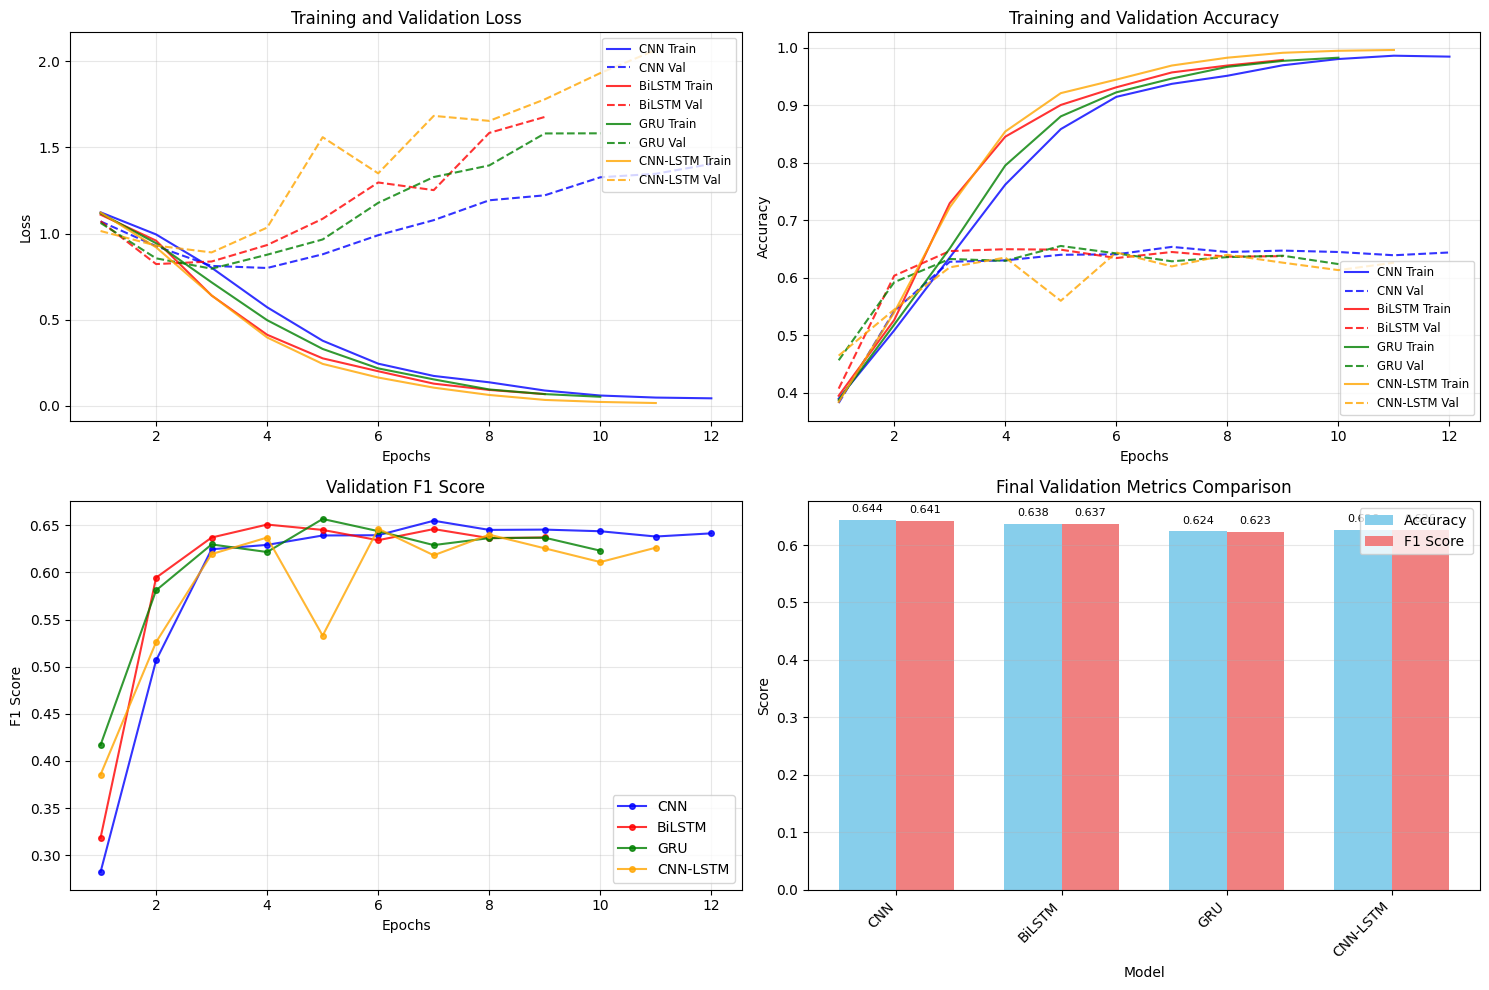

In [15]:
def plot_training_history(histories, model_names):
    """Plot training history for multiple models"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Colors for different models
    colors = ['blue', 'red', 'green', 'orange']
    
    # Plot training loss
    for i, (history, name) in enumerate(zip(histories, model_names)):
        epochs = range(1, len(history['train_loss']) + 1)
        axes[0, 0].plot(epochs, history['train_loss'], 
                       color=colors[i], linestyle='-', label=f'{name} Train', alpha=0.8)
        axes[0, 0].plot(epochs, history['val_loss'], 
                       color=colors[i], linestyle='--', label=f'{name} Val', alpha=0.8)
    
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend(loc='upper right', fontsize='small')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot training accuracy
    for i, (history, name) in enumerate(zip(histories, model_names)):
        epochs = range(1, len(history['train_acc']) + 1)
        axes[0, 1].plot(epochs, history['train_acc'], 
                       color=colors[i], linestyle='-', label=f'{name} Train', alpha=0.8)
        axes[0, 1].plot(epochs, history['val_acc'], 
                       color=colors[i], linestyle='--', label=f'{name} Val', alpha=0.8)
    
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].legend(loc='lower right', fontsize='small')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot validation F1 score
    for i, (history, name) in enumerate(zip(histories, model_names)):
        epochs = range(1, len(history['val_f1']) + 1)
        axes[1, 0].plot(epochs, history['val_f1'], 
                       color=colors[i], marker='o', label=name, markersize=4, alpha=0.8)
    
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].set_title('Validation F1 Score')
    axes[1, 0].legend(loc='lower right')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot final metrics comparison
    model_names_list = list(model_names)
    metrics = ['Accuracy', 'F1 Score']
    x = np.arange(len(model_names_list))
    width = 0.35
    
    # Get final validation metrics
    val_accs = [hist['val_acc'][-1] for hist in histories]
    val_f1s = [hist['val_f1'][-1] for hist in histories]
    
    bars1 = axes[1, 1].bar(x - width/2, val_accs, width, label='Accuracy', color='skyblue')
    bars2 = axes[1, 1].bar(x + width/2, val_f1s, width, label='F1 Score', color='lightcoral')
    
    axes[1, 1].set_xlabel('Model')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Final Validation Metrics Comparison')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(model_names_list, rotation=45, ha='right')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (acc, f1) in enumerate(zip(val_accs, val_f1s)):
        axes[1, 1].text(i - width/2, acc + 0.01, f'{acc:.3f}', 
                       ha='center', va='bottom', fontsize=8)
        axes[1, 1].text(i + width/2, f1 + 0.01, f'{f1:.3f}', 
                       ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('plots/dl_models_training_history_all.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot training histories for all models
plot_training_history(
    [cnn_history, bilstm_history, gru_history, cnn_lstm_history],
    ['CNN', 'BiLSTM', 'GRU', 'CNN-LSTM']
)

## Cell 12 - Compare Model Performance


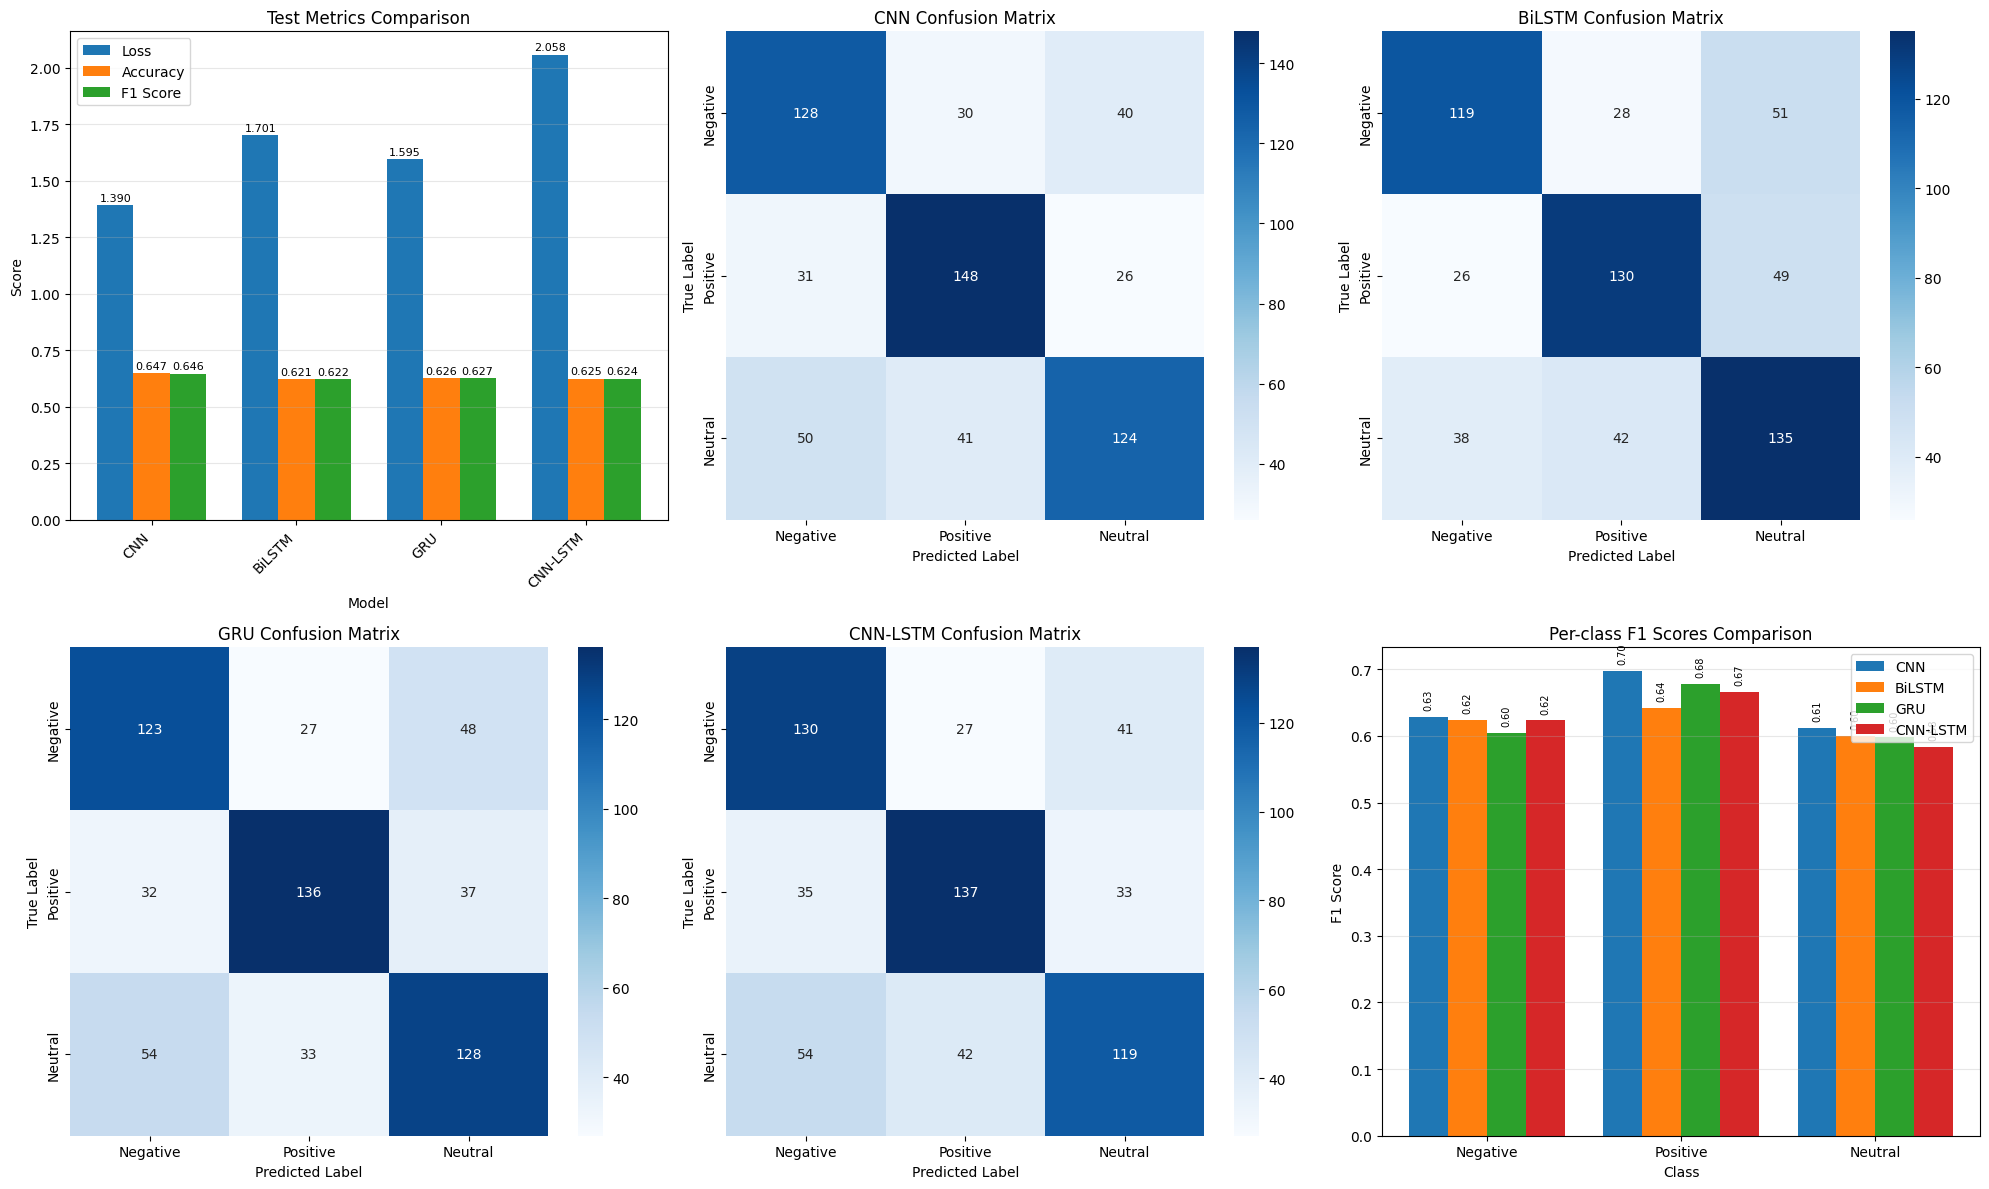


COMPREHENSIVE MODEL COMPARISON SUMMARY
Model        Accuracy   F1 Score   Loss       Parameters     
--------------------------------------------------------------------------------
CNN          0.6472     0.6461     1.3903    
BiLSTM       0.6214     0.6218     1.7007    
GRU          0.6262     0.6267     1.5953    
CNN-LSTM     0.6246     0.6238     2.0577    

Per-class F1 Scores:
--------------------------------------------------------------------------------
Model       Negative       Positive       Neutral        
--------------------------------------------------------------------------------
CNN         0.6290         0.6981         0.6123         
BiLSTM      0.6247         0.6420         0.6000         
GRU         0.6044         0.6783         0.5981         
CNN-LSTM    0.6235         0.6667         0.5833         


In [16]:
def compare_model_performance(results_dict, model_names, num_classes, class_names):
    """Compare performance of multiple models"""
    
    # Create figure with appropriate size for 4 models
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Test Metrics Comparison (Top left)
    ax1 = plt.subplot(2, 3, 1)
    metrics = ['Loss', 'Accuracy', 'F1 Score']
    model_list = list(model_names)
    x = np.arange(len(model_list))
    width = 0.25
    
    # Extract metrics for each model
    for i, metric in enumerate(metrics):
        values = []
        for model in model_list:
            if metric == 'Loss':
                values.append(results_dict[model]['test_metrics']['loss'])
            elif metric == 'Accuracy':
                values.append(results_dict[model]['test_metrics']['accuracy'])
            else:  # F1 Score
                values.append(results_dict[model]['test_metrics']['f1'])
        
        offset = (i - 1) * width
        bars = ax1.bar(x + offset, values, width, label=metric)
        
        # Add value labels
        for j, v in enumerate(values):
            ax1.text(j + offset, v + 0.01, f'{v:.3f}', 
                    ha='center', va='bottom', fontsize=8)
    
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Score')
    ax1.set_title('Test Metrics Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_list, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2-5. Confusion Matrices for each model
    positions = [(0, 1), (0, 2), (1, 0), (1, 1)]
    for idx, (model_name, pos) in enumerate(zip(model_list, positions)):
        ax = plt.subplot(2, 3, pos[0] * 3 + pos[1] + 1)
        cm = confusion_matrix(results_dict[model_name]['labels'], 
                             results_dict[model_name]['predictions'])
        labels = [class_names[i] for i in range(num_classes)]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=labels, yticklabels=labels)
        ax.set_title(f'{model_name} Confusion Matrix')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
    
    # 6. Per-class F1 Scores Comparison (Bottom right)
    ax6 = plt.subplot(2, 3, 6)
    x_classes = np.arange(num_classes)
    width = 0.2
    
    for i, model_name in enumerate(model_list):
        f1_per_class = f1_score(results_dict[model_name]['labels'], 
                               results_dict[model_name]['predictions'], 
                               average=None)
        offset = (i - 1.5) * width
        bars = ax6.bar(x_classes + offset, f1_per_class, width, label=model_name)
        
        # Add value labels
        for j, v in enumerate(f1_per_class):
            ax6.text(j + offset, v + 0.01, f'{v:.2f}', 
                    ha='center', va='bottom', fontsize=7, rotation=90)
    
    ax6.set_xlabel('Class')
    ax6.set_ylabel('F1 Score')
    ax6.set_title('Per-class F1 Scores Comparison')
    ax6.set_xticks(x_classes)
    ax6.set_xticklabels([class_names[i] for i in range(num_classes)])
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('plots/all_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print comprehensive summary
    print("\nCOMPREHENSIVE MODEL COMPARISON SUMMARY")
    print("="*80)
    print(f"{'Model':<12} {'Accuracy':<10} {'F1 Score':<10} {'Loss':<10} {'Parameters':<15}")
    print("-"*80)
    
    for model_name in model_list:
        metrics = results_dict[model_name]['test_metrics']
        # Get parameter count (you'll need to pass models_dict to this function)
        print(f"{model_name:<12} {metrics['accuracy']:<10.4f} {metrics['f1']:<10.4f} {metrics['loss']:<10.4f}")
    
    print("\nPer-class F1 Scores:")
    print("-"*80)
    print(f"{'Model':<12}", end='')
    for i in range(num_classes):
        print(f"{class_names[i]:<15}", end='')
    print()
    print("-"*80)
    
    for model_name in model_list:
        f1_per_class = f1_score(results_dict[model_name]['labels'], 
                               results_dict[model_name]['predictions'], 
                               average=None)
        print(f"{model_name:<12}", end='')
        for f1 in f1_per_class:
            print(f"{f1:<15.4f}", end='')
        print()

# Compare all model performance
results_dict = {
    'CNN': cnn_results,
    'BiLSTM': bilstm_results,
    'GRU': gru_results,
    'CNN-LSTM': cnn_lstm_results
}

compare_model_performance(results_dict, ['CNN', 'BiLSTM', 'GRU', 'CNN-LSTM'], 
                         num_classes, class_names)

## Cell 13 - Classification Reports


In [17]:
# Print detailed classification reports for all models
print("="*80)
print("DETAILED CLASSIFICATION REPORTS - ALL MODELS")
print("="*80)

models_to_report = [
    ('CNN', cnn_results),
    ('BiLSTM', bilstm_results),
    ('GRU', gru_results),
    ('CNN-LSTM', cnn_lstm_results)
]

for model_name, results in models_to_report:
    print(f"\n{model_name} Model:")
    print("-"*60)
    print(classification_report(
        results['labels'], 
        results['predictions'],
        target_names=[class_names[i] for i in range(num_classes)],
        digits=4
    ))

DETAILED CLASSIFICATION REPORTS - ALL MODELS

CNN Model:
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative     0.6124    0.6465    0.6290       198
    Positive     0.6758    0.7220    0.6981       205
     Neutral     0.6526    0.5767    0.6123       215

    accuracy                         0.6472       618
   macro avg     0.6470    0.6484    0.6465       618
weighted avg     0.6474    0.6472    0.6461       618


BiLSTM Model:
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative     0.6503    0.6010    0.6247       198
    Positive     0.6500    0.6341    0.6420       205
     Neutral     0.5745    0.6279    0.6000       215

    accuracy                         0.6214       618
   macro avg     0.6249    0.6210    0.6222       618
weighted avg     0.6238    0.6214    0.6218       618


GRU Model:
--------------------------------

## Cell 14 - Error Analysis


In [18]:
def analyze_errors(model, test_loader, model_name, num_samples=10):
    """Analyze model errors"""
    
    model.eval()
    errors = []
    
    with torch.no_grad():
        for batch in test_loader:
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(sequences)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            # Find errors
            error_mask = predicted != labels
            if error_mask.any():
                error_indices = error_mask.nonzero(as_tuple=True)[0]
                
                for idx in error_indices:
                    # Convert sequence back to text
                    seq = sequences[idx].cpu().numpy()
                    tokens = [preprocessor.idx2word.get(idx, '<UNK>') 
                             for idx in seq if idx not in [0, 2, 3]]  # Exclude special tokens
                    text = ' '.join(tokens)
                    
                    errors.append({
                        'text': text,
                        'true_label': class_names[labels[idx].item()],
                        'predicted_label': class_names[predicted[idx].item()],
                        'confidence': probs[idx].max().item(),
                        'probs': probs[idx].cpu().numpy()
                    })
    
    print(f"\n{model_name} - Error Analysis")
    print("="*70)
    print(f"Total errors: {len(errors)}")
    print(f"\nSample misclassified texts:")
    print("-"*70)
    
    # Sort by confidence (high confidence errors first)
    errors_sorted = sorted(errors, key=lambda x: x['confidence'], reverse=True)
    
    for i, error in enumerate(errors_sorted[:num_samples]):
        print(f"\nError {i+1}:")
        print(f"Text: {error['text'][:100]}...")
        print(f"True label: {error['true_label']}")
        print(f"Predicted: {error['predicted_label']}")
        print(f"Confidence: {error['confidence']:.4f}")
        
        # Show probabilities for all classes
        prob_str = ", ".join([f"{class_names[j]}: {error['probs'][j]:.3f}" 
                             for j in range(num_classes)])
        print(f"All probabilities: {prob_str}")

# Analyze errors for both models
analyze_errors(cnn_model, test_loader, "CNN", num_samples=5)
analyze_errors(bilstm_model, test_loader, "BiLSTM", num_samples=5)


CNN - Error Analysis
Total errors: 218

Sample misclassified texts:
----------------------------------------------------------------------

Error 1:
Text: আমি জানি রিয়াদ কোন ধরণের ক্যাপ্টেন.. তার ওপর আমরা ওপার বিশ্বাস রাখতে পারি. শুভকামনা প্রিয় রিয়াদ ভ...
True label: Negative
Predicted: Positive
Confidence: 1.0000
All probabilities: Negative: 0.000, Positive: 1.000, Neutral: 0.000

Error 2:
Text: নাচতে না জানলে উঠান বাঁকা...
True label: Neutral
Predicted: Negative
Confidence: 1.0000
All probabilities: Negative: 1.000, Positive: 0.000, Neutral: 0.000

Error 3:
Text: <UNK> <UNK> ওর কাহিনী তো সারাজিবন একই !...
True label: Negative
Predicted: Neutral
Confidence: 0.9999
All probabilities: Negative: 0.000, Positive: 0.000, Neutral: 1.000

Error 4:
Text: অবশ্যই লিটনের অনেক দেয়ার আছে তাই তাকে বারবার সুযোগও দেয়া হচ্ছে মুশফিকের উত্তরসূরি হিসেবে।...
True label: Positive
Predicted: Negative
Confidence: 0.9999
All probabilities: Negative: 1.000, Positive: 0.000, Neutral: 0.000

Error 5:
Text: ভ

## Cell 15 - Save Models and Results


In [19]:
# Save all models and results
def save_all_dl_models(models_dict, results_dict, preprocessor):
    """Save all deep learning models and results"""
    
    # Save models
    for model_name, model in models_dict.items():
        model_path = f'models/{model_name.lower()}_sentiment_model.pth'
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_config': {
                'vocab_size': preprocessor.vocab_size,
                'embedding_dim': 100,
                'num_classes': num_classes,
                'model_type': model_name
            },
            'test_metrics': results_dict[model_name]['test_metrics']
        }, model_path)
        print(f"Saved {model_name} model to {model_path}")
    
    # Save preprocessor
    import pickle
    with open('models/preprocessor.pkl', 'wb') as f:
        pickle.dump(preprocessor, f)
    print("Saved preprocessor")
    
    # Save embedding matrix
    np.save('embeddings/embedding_matrix.npy', embedding_matrix)
    print("Saved embedding matrix")
    
    # Save comprehensive results summary
    summary = {
        'models': list(models_dict.keys()),
        'results': {
            name: {
                'test_accuracy': results['test_metrics']['accuracy'],
                'test_f1': results['test_metrics']['f1'],
                'test_loss': results['test_metrics']['loss'],
                'training_epochs': len(results['history']['train_loss'])
            }
            for name, results in results_dict.items()
        },
        'dataset_info': {
            'num_samples': len(df),
            'num_classes': num_classes,
            'vocab_size': preprocessor.vocab_size,
            'max_seq_length': max_seq_length,
            'embedding_dim': 100
        },
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    with open('results/all_dl_models_summary.json', 'w') as f:
        json.dump(summary, f, indent=4)
    print("\nSaved results summary to results/all_dl_models_summary.json")
    
    return summary

# Save all models
models_dict = {
    'CNN': cnn_model,
    'BiLSTM': bilstm_model,
    'GRU': gru_model,
    'CNN-LSTM': cnn_lstm_model
}

results_dict = {
    'CNN': cnn_results,
    'BiLSTM': bilstm_results,
    'GRU': gru_results,
    'CNN-LSTM': cnn_lstm_results
}

summary = save_all_dl_models(models_dict, results_dict, preprocessor)

# Print final summary
print("\n" + "="*80)
print("FINAL SUMMARY - ALL DEEP LEARNING MODELS")
print("="*80)
print(f"Dataset: {summary['dataset_info']['num_samples']} samples, {summary['dataset_info']['num_classes']} classes")
print(f"Vocabulary size: {summary['dataset_info']['vocab_size']}")
print(f"Max sequence length: {summary['dataset_info']['max_seq_length']}")
print(f"Embedding dimension: {summary['dataset_info']['embedding_dim']}")

print(f"\nModel Performance Summary:")
print("-"*60)
print(f"{'Model':<12} {'Accuracy':<12} {'F1 Score':<12} {'Loss':<12}")
print("-"*60)

# Sort models by accuracy
sorted_models = sorted(summary['results'].items(), 
                      key=lambda x: x[1]['test_accuracy'], 
                      reverse=True)

for model, metrics in sorted_models:
    print(f"{model:<12} {metrics['test_accuracy']:<12.4f} "
          f"{metrics['test_f1']:<12.4f} {metrics['test_loss']:<12.4f}")

Saved CNN model to models/cnn_sentiment_model.pth
Saved BiLSTM model to models/bilstm_sentiment_model.pth
Saved GRU model to models/gru_sentiment_model.pth
Saved CNN-LSTM model to models/cnn-lstm_sentiment_model.pth
Saved preprocessor
Saved embedding matrix

Saved results summary to results/all_dl_models_summary.json

FINAL SUMMARY - ALL DEEP LEARNING MODELS
Dataset: 6180 samples, 3 classes
Vocabulary size: 6476
Max sequence length: 100
Embedding dimension: 100

Model Performance Summary:
------------------------------------------------------------
Model        Accuracy     F1 Score     Loss        
------------------------------------------------------------
CNN          0.6472       0.6461       1.3903      
GRU          0.6262       0.6267       1.5953      
CNN-LSTM     0.6246       0.6238       2.0577      
BiLSTM       0.6214       0.6218       1.7007      


## Cell 16 - Inference Example


In [20]:
def predict_sentiment(text, model, preprocessor, model_name):
    """Predict sentiment for a given text"""
    
    # Preprocess text
    sequence = preprocessor.text_to_indices(text, max_length=max_seq_length)
    sequence_tensor = torch.tensor([sequence], dtype=torch.long).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(sequence_tensor)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    # Get results
    predicted_class = predicted.item()
    confidence = probs[0][predicted_class].item()
    
    return {
        'text': text,
        'sentiment': class_names[predicted_class],
        'confidence': confidence,
        'probabilities': {class_names[i]: probs[0][i].item() for i in range(num_classes)}
    }

# Test examples
test_texts = [
    "এই পণ্যটি খুবই ভালো, আমি খুব সন্তুষ্ট।",
    "সার্ভিস একদম বাজে, কখনো কিনবেন না।",
    "মোটামুটি ঠিক আছে, দাম অনুযায়ী ভালো।",
    "অসাধারণ! আমার খুব পছন্দ হয়েছে।",
    "খুবই হতাশাজনক অভিজ্ঞতা।"
]

print("SENTIMENT PREDICTIONS")
print("="*70)

for model_name, model in models_dict.items():
    print(f"\n{model_name} Predictions:")
    print("-"*50)
    
    for text in test_texts[:3]:  # Show first 3 examples
        result = predict_sentiment(text, model, preprocessor, model_name)
        print(f"\nText: {result['text']}")
        print(f"Sentiment: {result['sentiment']} (Confidence: {result['confidence']:.4f})")
        print(f"Probabilities: {', '.join([f'{k}: {v:.4f}' for k, v in result['probabilities'].items()])}")

# Performance comparison visualization
print("\n\nPERFORMANCE COMPARISON")
print("="*70)
print(f"{'Model':<10} {'Accuracy':<10} {'F1 Score':<10} {'Parameters':<15}")
print("-"*50)
for model_name, model in models_dict.items():
    params = sum(p.numel() for p in model.parameters())
    acc = results_dict[model_name]['test_metrics']['accuracy']
    f1 = results_dict[model_name]['test_metrics']['f1']
    print(f"{model_name:<10} {acc:<10.4f} {f1:<10.4f} {params:<15,}")

SENTIMENT PREDICTIONS

CNN Predictions:
--------------------------------------------------

Text: এই পণ্যটি খুবই ভালো, আমি খুব সন্তুষ্ট।
Sentiment: Positive (Confidence: 0.8265)
Probabilities: Negative: 0.0032, Positive: 0.8265, Neutral: 0.1702

Text: সার্ভিস একদম বাজে, কখনো কিনবেন না।
Sentiment: Positive (Confidence: 0.9999)
Probabilities: Negative: 0.0000, Positive: 0.9999, Neutral: 0.0001

Text: মোটামুটি ঠিক আছে, দাম অনুযায়ী ভালো।
Sentiment: Negative (Confidence: 0.9647)
Probabilities: Negative: 0.9647, Positive: 0.0026, Neutral: 0.0327

BiLSTM Predictions:
--------------------------------------------------

Text: এই পণ্যটি খুবই ভালো, আমি খুব সন্তুষ্ট।
Sentiment: Positive (Confidence: 0.9754)
Probabilities: Negative: 0.0000, Positive: 0.9754, Neutral: 0.0245

Text: সার্ভিস একদম বাজে, কখনো কিনবেন না।
Sentiment: Positive (Confidence: 1.0000)
Probabilities: Negative: 0.0000, Positive: 1.0000, Neutral: 0.0000

Text: মোটামুটি ঠিক আছে, দাম অনুযায়ী ভালো।
Sentiment: Positive (Confidence: 